In [2]:
%load_ext autoreload
%autoreload 2     # モジュールを変更したときに自動でリロードするようにする
%matplotlib inline

In [3]:
import random
import numpy as np

# コイントスタスクの定義

In [4]:
class CoinToss():

  def __init__(self, head_probs, max_episode_step=30):
    self.head_probs = head_probs                # 表が出る確率のリスト
    self.max_episode_step = max_episode_step    # 試行（コイントス）回数の最大値
    self.toss_count = 0                         # 現在の試行回数

  def __len__(self):
    return len(self.head_probs)

  def reset(self):
    self.toss_count = 0

  def step(self, action):
    final_step = self.max_episode_step - 1
    if self.toss_count < final_step:
      is_done = False
    elif self.toss_count == final_step:
      is_done = True
    else:
      raise Exception("Step count reached to maximum. Please reset env.")

    if action < len(self.head_probs):
      head_prob = self.head_probs[action]
      if random.random() < head_prob:   # 表が出れば報酬がもらえる
        reward = 1.
      else:
        reward = 0.
      self.toss_count += 1

      return reward, is_done

    else:
      raise Exception("No. {} coin does not exist.".format(action))  

# エージェントの定義

In [5]:
class EpsilonGreedyAgent():
  def __init__(self, epsilon):
    self.epsilon = epsilon    # ランダムなアクションを取る確率
    self.V = []               # コインごとの平均価値を保持するリスト

  def policy(self):
    coins = range(len(self.V))
    if random.random() < self.epsilon:
      return random.choice(coins)   # ランダムにコインを選ぶ
    else:
      return np.argmax(self.V)      # 最も平均価値の高いコインを選ぶ

  def play(self, env):
    # Initialize estimation
    N = [0] * len(env)        # 表が出る確率のリストの長さの分だけコイン使用回数を保持するリストを用意する
    self.V = [0] * len(env)   # 表が出る確率のリストの長さの分だけ価値のリストを保持する

    env.reset()
    is_done = False
    rewards = []

    while not is_done:
      selected_coin = self.policy()               # 方策に従ってコインを選ぶ
      reward, is_done = env.step(selected_coin)   # 選んだコインでコイントスを行う
      rewards.append(reward)                      # 試行毎の報酬をリストに追加する

      n = N[selected_coin]                        # 今回選んだコインの前回までの使用回数を得る
      coin_average = self.V[selected_coin]        # 今回選んだコインの前回までの価値平均を得る
      new_average = (coin_average * n + reward) / (n + 1) # 今回の報酬を合わせて、新しい価値平均を求める
      N[selected_coin] += 1                       # 今回選んだコインの使用回数を更新する
      self.V[selected_coin] = new_average         # 今回選んだコインの価値平均を更新する

    return rewards

# イプシロン探索の評価

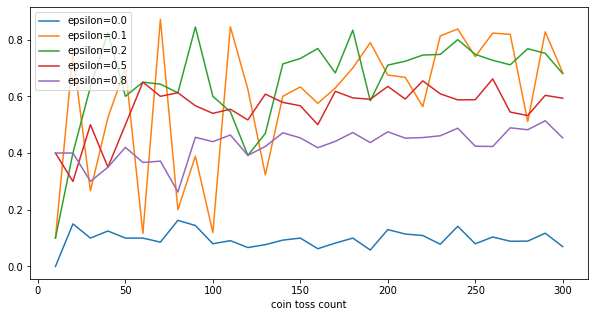

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

env = CoinToss([0.1, 0.5, 0.1, 0.9, 0.1])
epsilons = [0.0, 0.1, 0.2, 0.5, 0.8]      # ランダムに行動する確率のパターン
game_steps = list(range(10, 310, 10))     # コイントス回数を10回から300回まで10回刻みで試行する
result = {}

for e in epsilons:
  agent = EpsilonGreedyAgent(epsilon=e)
  means = []
  for s in game_steps:
    env.max_episode_step = s
    rewards = agent.play(env)
    means.append(np.mean(rewards))
  result["epsilon={}".format(e)] = means

result["coin toss count"] = game_steps
df_result = pd.DataFrame(result)
df_result.set_index("coin toss count", drop=True, inplace=True)
df_result.plot.line(figsize=(10, 5))